# Figures for Paper

## SODA (as same period as SOSE)

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [2]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms#.load()

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>

In [3]:
wmt_budget_terms = wmt_budget_terms.sel(time=slice('2006', '2010'))

In [4]:
import matplotlib.patches as patches

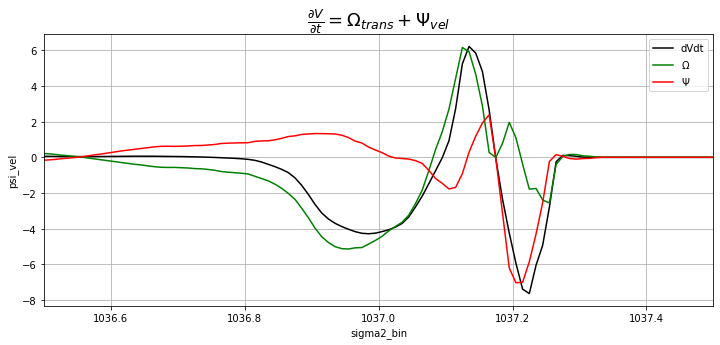

In [4]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\frac{\partial V}{\partial t} = \Omega_{trans} + \Psi_{vel}$', fontsize=18);

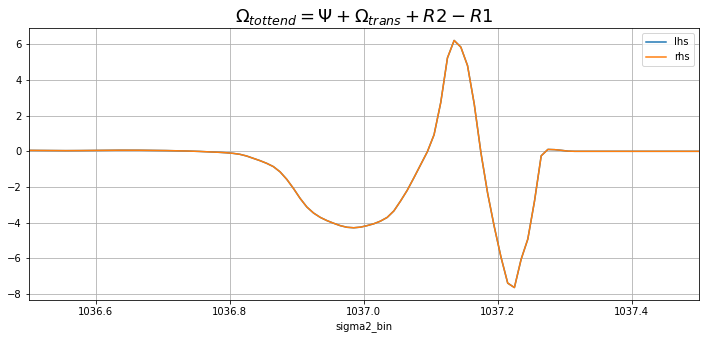

In [5]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='lhs')
(wmt_budget_terms.omega_trans + wmt_budget_terms.psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

In [6]:
wmt_budget_terms.dVdt.rolling(time=3).mean(dim='time')

<ipython-input-6-fe7e4ee15bfb>:1: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  wmt_budget_terms.dVdt.rolling(time=3).mean(dim='time')


<xarray.DataArray 'dVdt' (time: 182, sigma2_bin: 699)>
dask.array<truediv, shape=(182, 699), dtype=float64, chunksize=(162, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * time        (time) object 2006-01-09 01:00:00 ... 2010-12-24 01:00:00

In [7]:
wmt_budget_terms.dVdt.groupby('time.month').mean(dim='time')

<xarray.DataArray 'dVdt' (month: 12, sigma2_bin: 699)>
dask.array<stack, shape=(12, 699), dtype=float64, chunksize=(1, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [8]:
def anom(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=3).mean(dim='time') #monthly rolling mean
    return anom_rolled

In [9]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'),
                    wmt_budget_terms.psi_vel.rename('psi_vel'),
                    wmt_budget_terms.omega_trans.rename('omega_trans')])


In [10]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [11]:
clim_ds = anom_ds

In [16]:
#standardized anomaly
def monthly_std_anom(da):
    mu = da.groupby('time.month').mean(dim='time')
    x = da.groupby('time.month')
    std_clim = np.sqrt(np.mean(abs(x-mu)**2, axis=0))
    anom_norm = (x - mu) / std_clim
    return anom_norm

def yearly_std_anom(da):
    mu = da.groupby('time.year').mean(dim='time')
    x = da.groupby('time.year')
    std_clim = np.mean(np.sqrt(abs(x-mu)**2), axis=0)
    anom_norm = (x - mu) / std_clim
    return anom_norm

In [14]:
std_clim = wmt_budget_terms.psi_vel.groupby('time.month').std(dim='time')

In [15]:
std_clim

<xarray.DataArray 'psi_vel' (month: 12, sigma2_bin: 699)>
dask.array<stack, shape=(12, 699), dtype=float64, chunksize=(1, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [19]:
monthly_std_anom(wmt_budget_terms.psi_vel)

<xarray.DataArray 'psi_vel' (time: 182, sigma2_bin: 699)>
dask.array<truediv, shape=(182, 699), dtype=float64, chunksize=(4, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * time        (time) object 2006-01-09 01:00:00 ... 2010-12-24 01:00:00
    month       (time) int64 1 1 1 2 2 2 3 3 3 4 ... 10 10 10 11 11 11 12 12 12

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


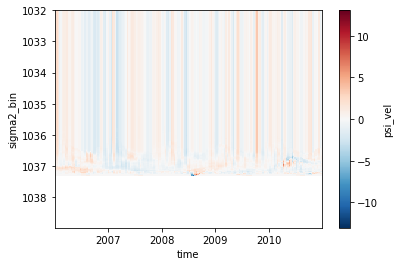

In [21]:
monthly_anom_norm = monthly_std_anom(wmt_budget_terms.psi_vel)
monthly_anom_norm.plot(x='time', yincrease=False)

In [97]:
anom(wmt_budget_terms.psi_vel)

<ipython-input-12-f16f072c98ab>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=3).mean(dim='time') #yearly rolling mean


<xarray.DataArray 'psi_vel' (time: 182, sigma2_bin: 699)>
dask.array<truediv, shape=(182, 699), dtype=float64, chunksize=(4, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * time        (time) object 2006-01-09 01:00:00 ... 2010-12-24 01:00:00
    month       (time) int64 1 1 1 2 2 2 3 3 3 4 ... 10 10 10 11 11 11 12 12 12

In [107]:
std_anom = anom(wmt_budget_terms.psi_vel) / clim_std

<ipython-input-12-f16f072c98ab>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=3).mean(dim='time') #yearly rolling mean
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4311: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [108]:
std_anom

,Array,Chunk
Bytes,11.65 MiB,5.47 kiB
Shape,"(182, 699, 12)","(4, 175, 1)"
Count,12063 Tasks,2976 Chunks
Type,float64,numpy.ndarray


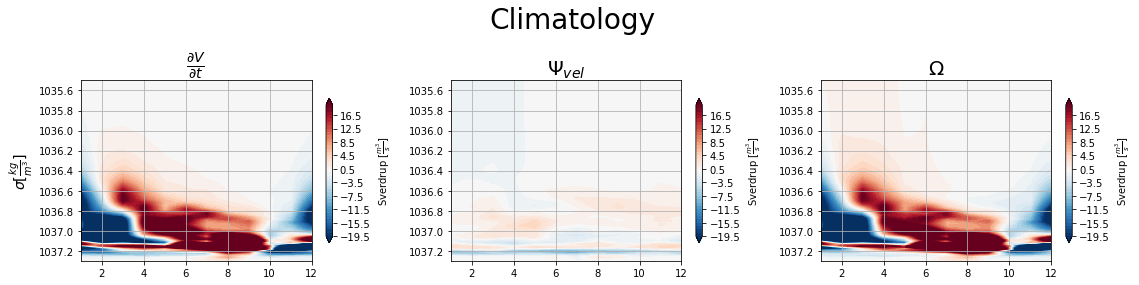

In [25]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4))#, sharex=True)

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_ylim(1037.3, 1035.5)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim(clim_ds.omega_trans)
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

In [23]:
year_start_index =[0, 36, 73, 109, 146]

In [24]:
wmt_budget_terms.psi_vel.time.values[year_start_index]

array([cftime.DatetimeJulian(2006, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2007, 1, 4, 1, 0, 0, 0),
       cftime.DatetimeJulian(2008, 1, 9, 1, 0, 0, 0),
       cftime.DatetimeJulian(2009, 1, 3, 1, 0, 0, 0),
       cftime.DatetimeJulian(2010, 1, 8, 1, 0, 0, 0)], dtype=object)

<ipython-input-12-f16f072c98ab>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=3).mean(dim='time') #yearly rolling mean
<ipython-input-47-1b1663f159ea>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax0.pcolormesh(dVdt_anom_rolled.time,
<ipython-input-12-f16f072c98ab>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=3).mean(dim='time') #yearly rolling mean
<ipython-input-47-1b1663f159ea>:17: MatplotlibDeprecationWarning: shading='flat' when X an

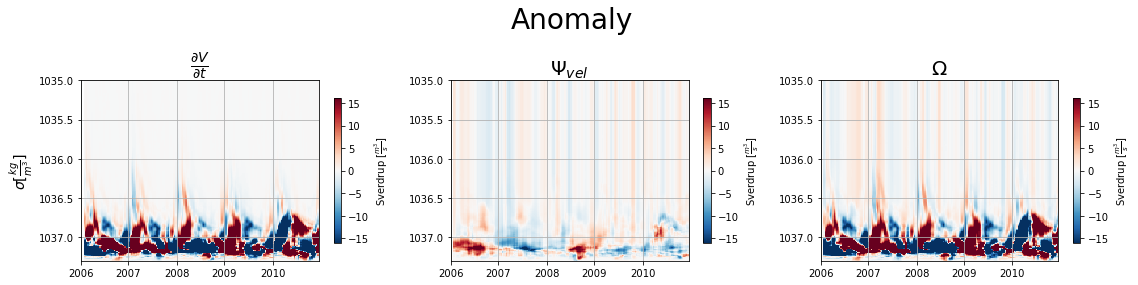

In [47]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4))#, sharex=True)

dVdt_anom_rolled = anom(anom_ds.dVdt) / 1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-16, vmax=16, cmap='RdBu_r')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_ylim(1037.3, 1035.)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(np.arange(2006, 2011))
ax0.grid()

psi_vel_anom_rolled = anom(anom_ds.psi_vel)
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-16, vmax=16, cmap='RdBu_r')
plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_ylim(1037.3, 1035.)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels(np.arange(2006, 2011))
ax1.grid()

omega_anom_rolled = anom(anom_ds.omega_trans)
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-16, vmax=16, cmap='RdBu_r')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_ylim(1037.3, 1035.)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels(np.arange(2006, 2011))
ax2.grid()

plt.suptitle('Anomaly', fontsize=28)
plt.tight_layout();

<ipython-input-25-7356cb2b788a>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax0.pcolormesh(dVdt_anom_rolled.time,
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
<ipython-input-25-7356cb2b788a>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigm

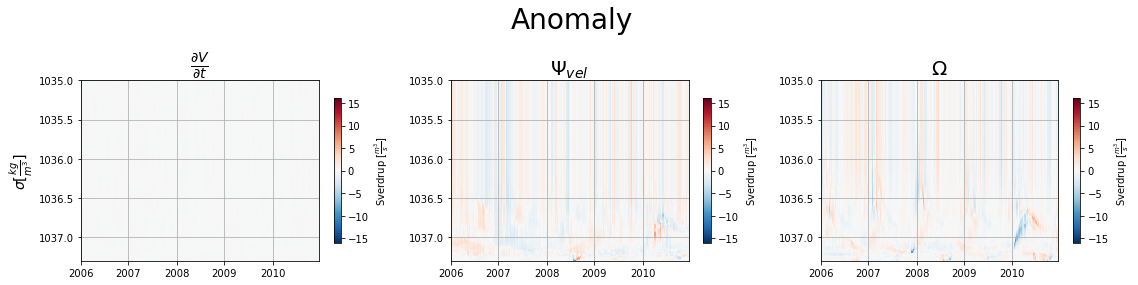

In [25]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4))#, sharex=True)

dVdt_anom_rolled = monthly_std_anom(anom_ds.dVdt) / 1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-16, vmax=16, cmap='RdBu_r')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_ylim(1037.3, 1035.)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(np.arange(2006, 2011))
ax0.grid()

psi_vel_anom_rolled = monthly_std_anom(anom_ds.psi_vel)
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-16, vmax=16, cmap='RdBu_r')
plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_ylim(1037.3, 1035.)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels(np.arange(2006, 2011))
ax1.grid()

omega_anom_rolled = monthly_std_anom(anom_ds.omega_trans)
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-16, vmax=16, cmap='RdBu_r')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_ylim(1037.3, 1035.)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels(np.arange(2006, 2011))
ax2.grid()

plt.suptitle('Anomaly', fontsize=28)
plt.tight_layout();